In [1]:
#Technologies: solar and battery

import pypsa
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

n=pypsa.Network()

#Snapshots
n.set_snapshots(value=pd.date_range(freq="h", start="2013-01-01", end="2014-01-01", inclusive='left'))
n.snapshot_weightings[:] *= 8760.0 / n.snapshot_weightings.sum()

c:\Users\denis\miniconda3\envs\pypsa-earth\lib\site-packages\pypsa\components.py:374: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

c:\Users\denis\miniconda3\envs\pypsa-earth\lib\site-packages\pypsa\components.py:374: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

c:\Users\denis\miniconda3\envs\pypsa-earth\lib\site-packages\pypsa\components.py:374: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

c:\Users\denis\miniconda3\envs\pypsa-earth\lib\site-packages\pypsa\components.py:374: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

c:\Users\denis\miniconda3\envs\pypsa-earth\lib\site-packages\pypsa\components.py:374: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

c:\Users\denis\miniconda3\envs\pypsa-earth\lib\site-packages

In [2]:
#I create the bus 

n.madd("Bus", ["onebus"], x=0.1, y=0.2, carrier="AC", v_nom=20)

n.buses


,x,y,carrier,v_nom,type,unit,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,sub_network
Bus,,,,,,,,,,,
onebus,0.1,0.2,AC,20.0,,None,1.0,0.0,inf,PQ,


In [3]:

# #I import a time series for generation 

with xr.open_dataset(r'C:\Users\denis\OneDrive\Desktop\Mini grids\pypsa-distribution\time_series\Generation_timeseries\profile_solar.nc') as ds:

    solar=ds["profile"].transpose("time", "bus").to_pandas()

#I take just the first column(one bus)

solar=solar.iloc[:,0:1]

# solar=pd.DataFrame(solar,
#                   index=n.snapshots)

solar=solar.reindex(n.snapshots)
solar=solar["0"]
#I create a numpy array 
#import numpy as np
# solar=np.array(solar)
type(solar)

pandas.core.series.Series

In [4]:
#I connect a generator to the bus "onebus"

n.madd("Generator", ["solargenerator"], bus = "onebus", p_nom=1, p_nom_extendable=True, p_nom_min=0.7, 
       p_nom_max=1.2, p_max_pu=solar, carrier="solar", capital_cost=400, efficiency=0.3, marginal_cost=0.001)

#Not to have the warning: p_max_pu=solar_df, solar_df=solar["0"]


Index(['solargenerator'], dtype='object')

In [5]:
n.generators.p_max_pu

Generator
solargenerator   NaN
Name: p_max_pu, dtype: float64

In [6]:
n.generators

,bus,p_nom,p_nom_extendable,p_nom_min,p_nom_max,p_max_pu,carrier,capital_cost,efficiency,marginal_cost,...,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,p_nom_opt
Generator,,,,,,,,,,,,,,,,,,,,,
solargenerator,onebus,1.0,True,0.7,1.2,NaN,solar,400.0,0.3,0.001,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0


In [7]:
#I import a time series for load as pandas dataframe
import pandas as pd

load=pd.read_csv(r'C:\Users\denis\OneDrive\Desktop\Mini grids\pypsa-distribution\time_series\Load_timeseries\sample_profile.csv', parse_dates=True)

#Used at first, now changed to make it look similar to solar data
# date_index=pd.date_range('01/01/2013', periods=8760, freq='h')
# date_index = pd.DataFrame(date_index, columns=['time'])
# date_index['bus 0']=load_df['bus 0']
# load=date_index

load=load["bus 0"]
load=pd.DataFrame(load)
load = load.set_index([n.snapshots])


load_df=load["bus 0"]

print(load_df)
#p_set=load_df

#I create a numpy array 
#load=np.array(load)



snapshot
2013-01-01 00:00:00    18.559885
2013-01-01 01:00:00    20.595279
2013-01-01 02:00:00    14.449810
2013-01-01 03:00:00    16.499849
2013-01-01 04:00:00    13.390089
                         ...    
2013-12-31 19:00:00    57.438227
2013-12-31 20:00:00    35.517246
2013-12-31 21:00:00    33.213649
2013-12-31 22:00:00    30.535195
2013-12-31 23:00:00    25.422619
Freq: H, Name: bus 0, Length: 8760, dtype: float64


In [8]:

#I connect the load to the bus "onebus"

n.madd("Load", ["MyLoad"], bus=["onebus"], carrier="AC", p_set = load)
 #p_set [MW]

#Not to have the warning: load_df=load["bus 0"] and p_set=load_df

# n.loads



Index(['MyLoad'], dtype='object')

In [9]:
n.loads

,bus,carrier,type,p_set,q_set,sign
Load,,,,,,
MyLoad,onebus,AC,,0.0,0.0,-1.0


In [11]:
#n.madd("StorageUnit", ["mySU"] , bus="onebus", p_nom=50, capital_cost=300)

In [12]:
n.madd("StorageUnit",["StorUni"], bus="onebus", marginal_cost=10, inflow=50, p_nom_extendable=True, capital_cost=10, p_nom=2000, 
       efficiency_dispatch=0.5, cyclic_state_of_charge=True, state_of_charge_initial=1000)

Index(['StorUni'], dtype='object')

In [13]:
#I want to see my whole network:

print(n)

PyPSA Network
Components:
 - Bus: 1
 - Generator: 1
 - Load: 1
 - StorageUnit: 1
Snapshots: 8760


<AxesSubplot: xlabel='snapshot', ylabel='MW'>

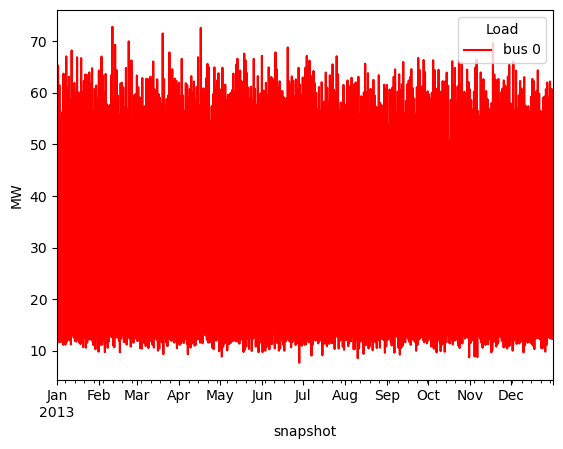

In [ ]:
#Plotting the load
n.loads_t.p_set.plot(color='red', ylabel='MW')


In [16]:
#Optimization
from pypsa.linopf import ilopf

solver_name="gurobi"

n.lopf(n.snapshots, solver_name=solver_name, pyomo=False)


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 0.9s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-07
Read LP format model from file C:\Users\denis\AppData\Local\Temp\pypsa-problem-c1djbzvd.lp
Reading time = 0.20 seconds
obj: 87600 rows, 43803 columns, 166440 nonzeros
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 87600 rows, 43803 columns and 166440 nonzeros
Model fingerprint: 0x95b12d9a
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [1e-03, 4e+02]
  Bounds range     [7e-01, 2e+04]
  RHS range        [5e+01, 5e+01]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 61320 rows and 17522 columns
Presolve time: 0.12s
Presolved: 26280 rows, 26281 columns, 70080 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.0120000e+04   0.000000e+00   0.000000e+00      0s

Use crossover to conver

INFO:pypsa.linopf:Optimization successful. Objective value: -2.01e+04


('ok', 'optimal')

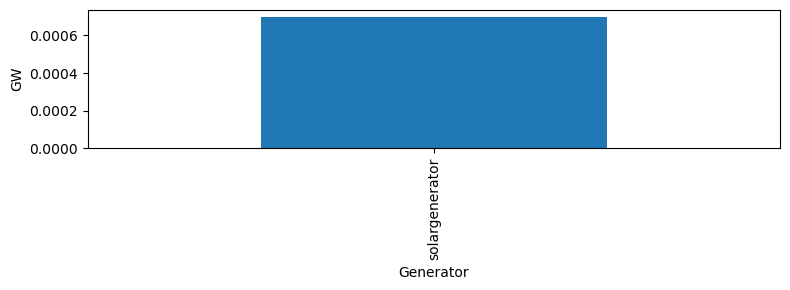

In [19]:
n.generators.p_nom_opt.div(1e3).plot.bar(ylabel="GW", figsize=(8, 3))
plt.tight_layout()